# SMC2017: Exercise set III

## Setup

In [1]:
import numpy as np
from scipy import stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## III.1 Metropolis-Hastings

Distribution of interest
$$
\pi(x) \propto \sin^2(x) \exp(-|x|) \quad(x \in \mathbb{R})
$$
This distribution is normalized by dividing through 0.8.

Use Gaussian random walk as proposal, i.e. $q(x\,|\,x') = N(x\,|\,x',\,\sigma)$. Different values of $\sigma$ should be tried.

In [6]:
def metropolis_hastings(M, sigma=1):
    x = np.zeros((M + 1,))
    # Initial state
    x[0] = 1
    # Iterate the chain
    for i in range(M):
        # Sample a new value
        xp = stats.norm.rvs(x[i], sigma, 1)
        # Sample to be compared to the acceptance probability
        u = stats.uniform.rvs()
        # Terms in the second part of the acceptance probability
        # Proposal is symmetric, so terms containing the proposal will
        # cancel each other out
        rhs = np.power(np.sin(xp), 2) * np.exp(-np.abs(xp)) / \
            (np.power(np.sin(x[i]), 2) * np.exp(-np.abs(x[i])))
        # Acceptance probability
        alpha = min(1, rhs)
        # Set next state depending on acceptance probability
        if u <= alpha:
            x[i + 1] = xp
        else:
            x[i + 1] = x[i]
            
    return x

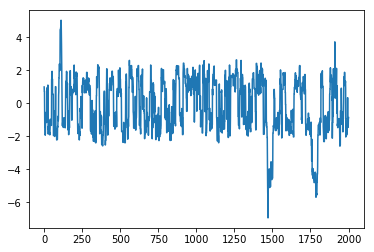

In [22]:
xs = metropolis_hastings(2000, sigma=1)

fig, ax = plt.subplots()
ax.plot(xs)

The sampling at least seems to be bounded in some way and seems to explore a sine curve of some type.

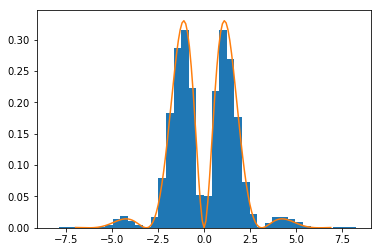

In [16]:
xs = metropolis_hastings(50000)

# Remove burn-in and use the rest of the samples for a histogram
burnin = 1000
fig, ax = plt.subplots()
ax.hist(xs[burnin:], normed=True, bins=40)

# Overlay the actual distribution
x_grid = np.arange(-7, 7, 0.1)
pdf = 5. / 4. * np.power(np.sin(x_grid), 2) * np.exp(-np.abs(x_grid))
ax.plot(x_grid, pdf)

Try a different value of $\sigma$.

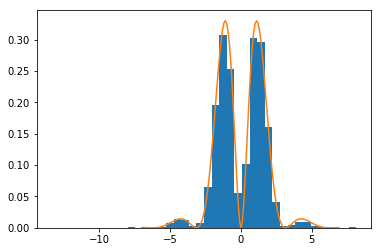

In [17]:
xs = metropolis_hastings(50000, sigma=2)

# Remove burn-in and use the rest of the samples for a histogram
burnin = 1000
fig, ax = plt.subplots()
ax.hist(xs[burnin:], normed=True, bins=40)

# Overlay the actual distribution
x_grid = np.arange(-7, 7, 0.1)
pdf = 5. / 4. * np.power(np.sin(x_grid), 2) * np.exp(-np.abs(x_grid))
ax.plot(x_grid, pdf)

## III.2 Gibbs sampling

Target distribution is
$$
\pi(x) = N\left(x\,\big|\,\begin{pmatrix} 7 \\ 3 \end{pmatrix},\,
\begin{pmatrix} 0.3 & 0.1 \\ 0.1 & 1 \end{pmatrix}\right)
$$
and Gibbs sampling for each component should be used. 

Starting point is supposed to be $(0, 0)$.

The two marginal distributions are
$$
\begin{align}
\pi(x^1\,|\,x^2[i - 1]) &= N\left(x^1\,\big|\,
7 + \frac{0.1}{1} (x^2[i - 1] - 3), 0.3 - \frac{0.1^2}{1}\right) \\ 
&= N\left(x^1\,\big|\,6.7 + 0.1 \cdot x^2[i - 1], 0.29\right)
\end{align}
$$
and
$$
\begin{align}
\pi(x^2\,|\,x^1[i]) &= N\left(x^2\,\big|\,
3 + \frac{0.1}{0.3} (x^1[i] - 7), 1 - \frac{0.1^2}{0.3}\right) \\ 
&= N\left(x^1\,\big|\,\frac{2}{3} + \frac{1}{3} \cdot x^1[i], \frac{29}{30}\right)
\end{align}
$$

In [24]:
def gibbs_sampler(M):
    # Array for storing results
    xs = np.zeros((M + 1, 2))
    # Initial state
    xs[0, :] = np.array([0, 0])
    # Iterate the Markov chain
    for i in range(1, M + 1):
        # Sample the first component
        xs[i, 0] = stats.norm.rvs(6.7 + 0.1 * xs[i - 1, 1], 0.29, 1)
        # Sample the second component
        xs[i, 1] = stats.norm.rvs(2. / 3. + 1. / 3. * xs[i, 0], 29. / 30.)
        
    return xs

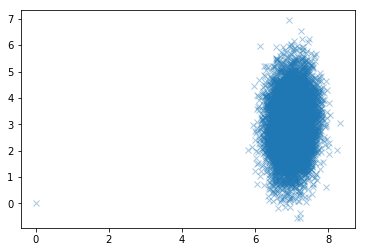

In [32]:
xs = gibbs_sampler(10000)

fig, ax = plt.subplots()
ax.plot(xs[:, 0], xs[:, 1], 'x', alpha=0.4)

## III.3 Resampling

Some theoretical justifications were done on paper. See `exercises_on_paper`.

Different resampling strategies are to be explored. The different resampling algorithms are implemented below. They take a set of normalized weights / probabilities and return the ancestor indices from $0,\dots, N - 1$.

Algorithms can be found [here](http://sait.cie.put.poznan.pl/38/SAIT_38_02.pdf).

In [2]:
def multinomial_resampling(ws):
    # Determine number of elements
    N = len(ws)
    # Create a sample of uniform random numbers
    u_sample = stats.uniform.rvs(size=N)
    # Transform them appropriately
    u = np.zeros((N,))
    u[N - 1] = np.power(u_sample[N - 1], 1 / N)
    for i in range(N - 1, 0, -1):
        u[i - 1] = u[i] * np.power(u_sample[i - 1], 1 / i)
        
    # Output array
    out = np.zeros((N,), dtype=int)
    
    # Find the right ranges
    total = 0.0
    i = 0
    j = 0
    while j < N:
        total += ws[i]
        while j < N and total > u[j]:
            out[j] = i
            j += 1
            
        # Increase weight counter
        i += 1
        
    return out


def systematic_resampling(ws):
    # Determine number of elements
    N = len(ws)        
    # Output array
    out = np.zeros((N,), dtype=int)
    
    # Create one single uniformly distributed number
    u = stats.uniform.rvs() / N
    # Find the right ranges
    total = ws[0]
    j = 0
    for i in range(N):
        while total < u:
            j += 1
            total += ws[j]
            
        # Once the right index is found, save it
        out[i] = j
        u = u + 1 / N
        
    return out


def stratified_resampling(ws):
    # Determine number of elements
    N = len(ws)        
    # Output array
    out = np.zeros((N,), dtype=int)
    
    # Find the right ranges
    total = ws[0]
    j = 0
    for i in range(N):
        u = (stats.uniform.rvs() + i) / N
        while total < u:
            j += 1
            total += ws[j]
            
        # Once the right index is found, save it
        out[i] = j
        
    return out

Testing the sampling algorithms for validity.

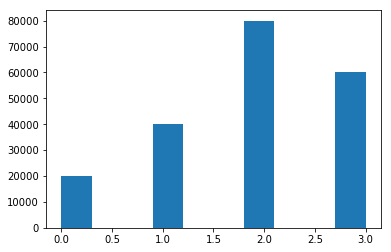

In [57]:
M = 50000
vals = np.zeros((4, M))

for i in range(M):
    vals[:, i] = multinomial_resampling([0.1, 0.2, 0.4, 0.3])
    
fig, ax = plt.subplots()
ax.hist(np.reshape(vals, (4 * M,)));

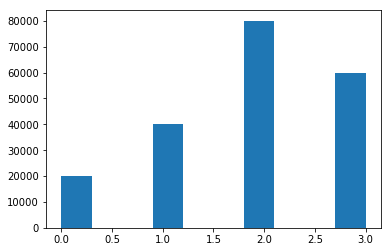

In [63]:
M = 50000
vals = np.zeros((4, M))

for i in range(M):
    vals[:, i] = systematic_resampling([0.1, 0.2, 0.4, 0.3])
    
fig, ax = plt.subplots()
ax.hist(np.reshape(vals, (4 * M,)));

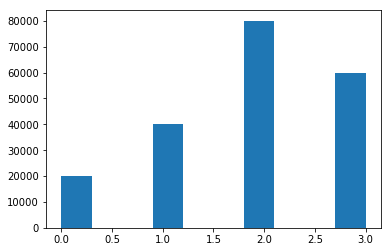

In [61]:
M = 50000
vals = np.zeros((4, M))

for i in range(M):
    vals[:, i] = stratified_resampling([0.1, 0.2, 0.4, 0.3])
    
fig, ax = plt.subplots()
ax.hist(np.reshape(vals, (4 * M,)));

Here the actual exercise is solved.

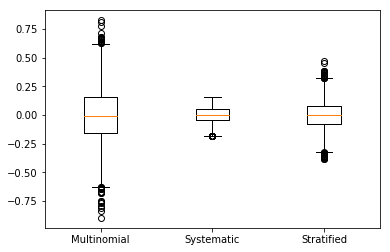

In [73]:
# 100 particles from some distribution
xs = stats.norm.rvs(1, 2, 100)
# Arbitrary weights
ws = stats.uniform.rvs(size=100)
# Normalize
ws /= np.sum(ws)

# Calculate the estimator m-hat
mhat = np.sum(ws * xs)

# Run the resampling M times each
M = 5000
mhatres = np.zeros((M, 3))
for i in range(M):
    # Multinomial resampling
    ancestors = multinomial_resampling(ws)
    mhatres[i, 0] = np.mean(xs[ancestors])
    
    # Systematic resampling
    ancestors = systematic_resampling(ws)
    mhatres[i, 1] = np.mean(xs[ancestors])
    
    # Stratified resampling
    ancestors = stratified_resampling(ws)
    mhatres[i, 2] = np.mean(xs[ancestors])
    
fig, ax = plt.subplots()
ax.boxplot(mhatres - mhat, labels=['Multinomial', 'Systematic', 'Stratified']);

Systematic resampling seems to lead to the smallest variance of the three compared resampling schemes.

## III.4 Path-space view

Stochastic volatility model
$$
\begin{align}
x_t\,|\,x_{t - 1} &\sim N(x_t; \phi \cdot x_{t - 1}, \sigma^2) \\
y_t\,|\,x_t &\sim N(y_t; 0, \beta^2 \cdot \exp(x_t))
\end{align}
$$
with parameter vector $\theta = (\phi, \sigma, \beta)$.

Fix the parameter values at $\theta = (0.98, 0.16, 0.70)$.

Load the data for the model.

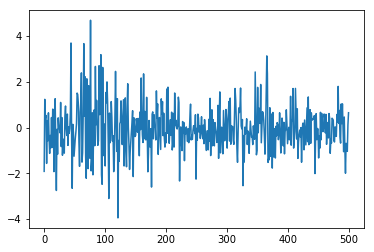

In [3]:
path = '..\\..\\..\\..\\course_material\\exercise_sheets\\'

data = pd.read_csv(path + 'seOMXlogreturns2012to2014.csv', 
                   header=None, names=['logreturn'])
ys = data.logreturn.values

fig, ax = plt.subplots()
ax.plot(ys)

The bootstrap particle filter below keeps track of the ancestors so that the trajectories can be reconstructed.

In [4]:
theta = [0.98, 0.16, 0.70]

def trajectories_BPF(y, N=30, sampling='multinomial', ess_max=None):
    # Determine the number of time steps
    T = len(y)
    
    # Save the history
    xs = np.zeros((N, T + 1))
    ancs = np.zeros((N, T + 1), dtype=int)
    ws = np.zeros((N, T + 1))
    
    # Initialisation
    xs[:, 0] = stats.norm.rvs(0, 1, N) * theta[1]
    ws[:, 0] = 1 / N * np.ones((N,))
    ancs[:, 0] = range(N)
    
    # Loop through all time steps
    for t in range(T):
        # Resample
        
        # Calculate effective sample size
        ess = 1 / np.sum(np.power(ws[:, t], 2))
        # If ess_max is not None, only do resampling if ESS is larger
        # than the set threshold
        if ess_max is None or ess < ess_max:
            if sampling == 'multinomial':
                ancs[:, t + 1] = np.random.choice(range(N), size=N, 
                                                  replace=True, p=ws[:, t])
            elif sampling == 'systematic':
                ancs[:, t + 1] = systematic_resampling(ws[:, t])
            else:
                raise ValueError("Sampling scheme {} unknown.".format(sampling))
        else:
            ancs[:, t + 1] = ancs[:, t]
        
        # Propagate
        xs[:, t + 1] = stats.norm.rvs(0, 1, N) * theta[1] + \
            theta[0] * xs[ancs[:, t + 1], t]
        
        # Weight
        logws = stats.norm.logpdf(y[t], loc=0,
                               scale=(theta[2] * np.exp(xs[:, t + 1] / 2)))
        # Substract maximum
        logws -= np.max(logws)
        # Normalize weights to be probabilities
        ws[:, t + 1] = np.exp(logws) / np.sum(np.exp(logws))
        
    return xs, ws, ancs

Run the particle filter to create a set of paths.

In [63]:
N = 20
xs, ws, ancs = trajectories_BPF(ys[:60], N=N)

Retract all the different paths. Those that die out and the ones that actually survive until the end.

In [64]:
# To plot the trajectories of the dead particles in gray
# We have to store which ones died and save their trajectories
dead_particles = []

# Length of the data
T = xs.shape[1] - 1
for t in range(1, T + 1):
    dead_ind = np.unique(np.setdiff1d(range(N), ancs[:, t]), axis=0)
    traj = np.zeros((len(dead_ind), t))
    ancestors = dead_ind
    for s in range(t, 0, -1):
        ancestors = ancs[ancestors, s - 1]
        traj[:, s - 1] = xs[ancestors, s - 1]
        
    dead_particles.append(traj)
    
# Retract the actual trajectory of all particles that survived
# until time T
traj_survived = np.zeros((N, T + 1))
traj_survived[:, T] = xs[:, T]
ancestors = range(N)
for t in range(T, 0, -1):
        ancestors = ancs[ancestors, t - 1]
        traj_survived[:, t - 1] = xs[ancestors, t - 1]

Plot all the trajectories

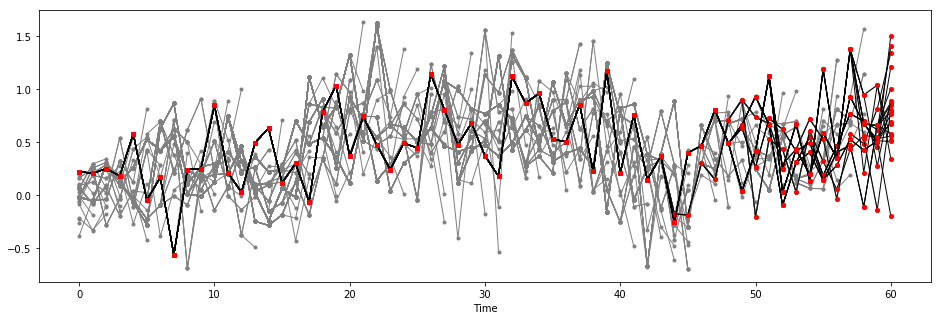

In [70]:
fig, ax = plt.subplots(figsize=(16, 5))

for traj in dead_particles:
    for i in range(traj.shape[0]):
        ax.plot(traj[i, :], 'o-', linestyle='-', 
                color='grey', markersize=3, lw=1,
                alpha=1, antialiased=True);
        
for i in range(N):
    ax.plot(traj_survived[i, :], 'o-', linestyle='-', markeredgecolor='r',
                markerfacecolor='r',
                color='k', markersize=4, lw=1,
                alpha=1, antialiased=True);
    
ax.set_xlabel('Time')

Put it all into one function

In [5]:
def plot_trajectories(N=20, Tmax=60, sampling='multinomial', ess_max=None):
    xs, ws, ancs = trajectories_BPF(ys[:Tmax], N=N, 
                                    sampling=sampling, 
                                    ess_max=ess_max)
    
    # To plot the trajectories of the dead particles in gray
    # We have to store which ones died and save their trajectories
    dead_particles = []

    # Length of the data
    T = xs.shape[1] - 1
    for t in range(1, T + 1):
        # It is not necessary to find the ancestor lines if no 
        # particles died
        difference = np.setdiff1d(range(N), ancs[:, t])
        if len(difference) == 0:
            continue
            
        dead_ind = np.unique(difference)
        traj = np.zeros((len(dead_ind), t))
        ancestors = dead_ind
        for s in range(t, 0, -1):
            ancestors = ancs[ancestors, s - 1]
            traj[:, s - 1] = xs[ancestors, s - 1]

        dead_particles.append(traj)

    # Retract the actual trajectory of all particles that survived
    # until time T
    traj_survived = np.zeros((N, T + 1))
    traj_survived[:, T] = xs[:, T]
    ancestors = range(N)
    for t in range(T, 0, -1):
        ancestors = ancs[ancestors, t - 1]
        traj_survived[:, t - 1] = xs[ancestors, t - 1]
            
    fig, ax = plt.subplots(figsize=(16, 5))

    for traj in dead_particles:
        for i in range(traj.shape[0]):
            ax.plot(traj[i, :], 'o-', linestyle='-', 
                    color='grey', markersize=3, lw=1,
                    alpha=0.8, antialiased=True);

    for i in range(N):
        ax.plot(traj_survived[i, :], 'o-', linestyle='-', 
                markeredgecolor='r',
                markerfacecolor='r',
                color='k', markersize=4, lw=1,
                alpha=1, antialiased=True);

    ax.set_xlabel('Time')

Different sampling techniques

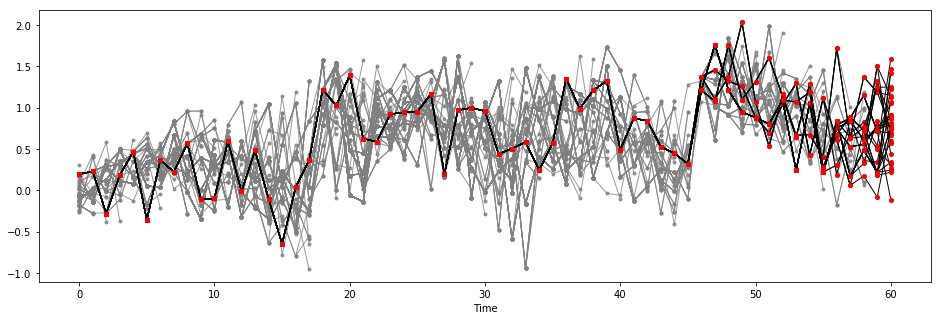

In [88]:
plot_trajectories(N=30)

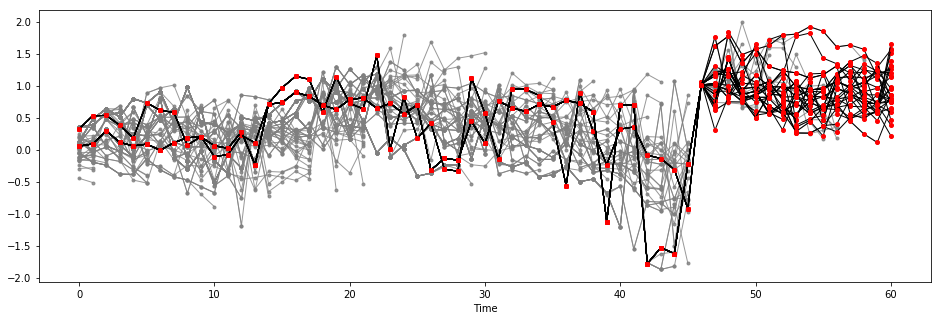

In [89]:
plot_trajectories(sampling='systematic', N=30)

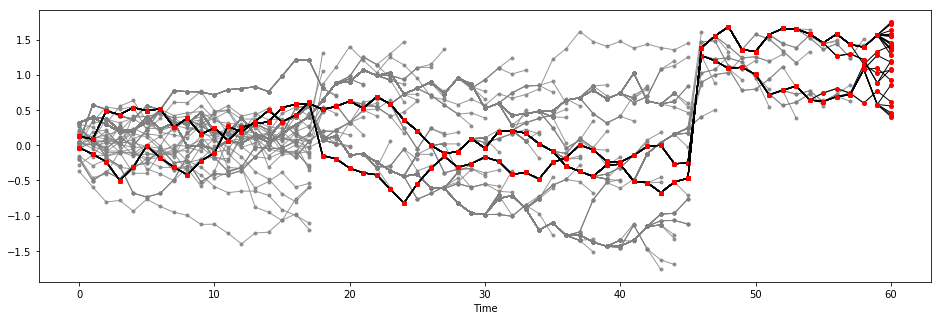

In [102]:
plot_trajectories(ess_max=15, N=30)

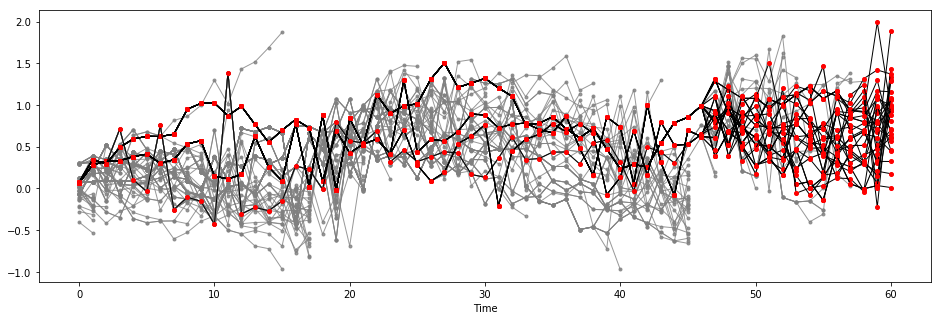

In [9]:
plot_trajectories(ess_max=None, N=30, sampling='systematic')

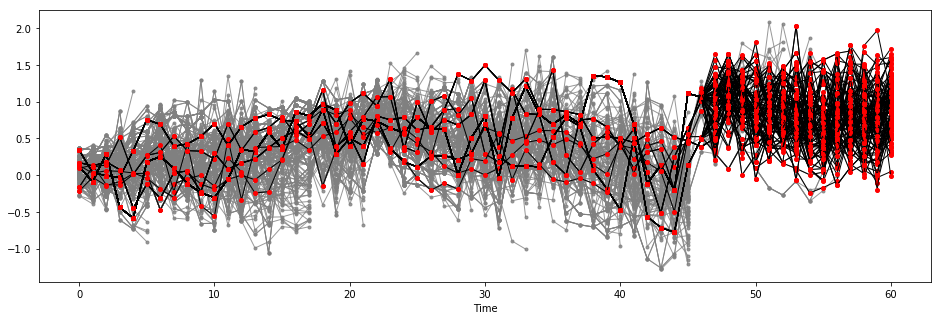

In [8]:
plot_trajectories(ess_max=None, N=100, sampling='systematic')